<a href="https://colab.research.google.com/github/DurdenTyler2008/University-of-AI/blob/main/16_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В одной из баз - резюме или квартир - сделайте callback, который будет выводить на каждой эпохе:

1. Текущую mae
2. График mae по всем эпохам на обучающей и проверочная выборках
3. Текущий scatter
4. Текущую гистограмму ошибок
5. Время обучения на эпохе, время обучения суммарное и сколько времени остаётся до конца обучения
6. Изменяется ли шаг обучения, если начинается “пила” или mae выходит на плато
7. Сохраняет в .h5 сеть с лучшей точностью
*желательно использовать clear_output и verbose=0
**callback должен быть самописный, нельзя использовать готовые

In [1]:
import numpy as np 
import pandas as pd 

from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras import utils 
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop 
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.callbacks import LambdaCallback 
from tensorflow.keras.models import load_model

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error 

import time
import random  
import math 
import os
import re 
import matplotlib.pyplot as plt 
%matplotlib inline

from IPython.display import clear_output


In [2]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls "/content/drive/MyDrive"    # читаю директории

 1_2.jpg	       city_temperature.csv   sonar.csv
 14text.txt	      'Colab Notebooks'       train.csv
 2_2.jpg	       Diseases		      train_vector_1.csv
 3_2.jpg	       file_csv.csv	      train_vector_1.gsheet
 3_3.jpg	       hh_fixed.csv	      unknown
 4_2.jpg	       iris.csv		      wine_base.csv
 4.jpg		       lkk_meters.csv	      zakupki_hack.csv
 7_2_kolorpaint.jpeg  'Matplotlib&Seaborn'    Автомобили.zip
 7_kolorpaint.jpeg     moscow.csv	      Болезни.zip
 7kolorpaint.png       moscow.h5	     'Задача 2_6.png'
 AIFramework	       Pandas1_ultra-pro     'Тексты писателей.zip'
 cars_new.csv	       Pandas2


In [3]:
df = pd.read_csv("/content/drive/My Drive/moscow.csv", sep=";")   # читаю файл
df.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
1,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
3,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."


In [4]:
df = df.iloc[::2,:]       # избавляюсь от лишних строк
data = df.values   
df.head() 

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."
6,1,Шаболовская м.,12п,8/12 ?,Б,Р,38/15/7,11200000.0,NaN,NaN,25.07.2019,7.0,Привлекательные,"Предлагаю 1- комн квартиру, в шаговой доступно..."
8,1,Бабушкинская м.,15п,4/14 П,NaN,С,34/17/8,6250000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,Продается хорошая 1 комнатная квартира. 1 взро...


In [5]:
print("названия столбов: \n", df.columns)

названия столбов: 
 Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')


In [ ]:
# xTrain - Комнат; Метро / ЖД станции; От станции; Дом; Балкон; Санузел; Площадь (числовые значения)
# xTrainC - Примечание (тексты о квартирах)
# yTrain Цена, руб()

Обрабатываю столбец 0 "Комнат"

In [7]:
def getRoomsCount(d, maxRoomCount): # функция количества комнат
    roomsCountStr = d[0]            # d[0] строкa с числом комнат

    roomsCount = 0
    try:
        roomsCount = int(roomsCountStr)       # строка в число
        if (roomsCount > maxRoomCount): 
          roomsCount = maxRoomCount           # Если число комнат больше максимального, то присваиваем максимальное
    except:                                   # Если не получается превратить строку в число
        if (roomsCountStr == roomsCountStr):  # Проверяем строку на nan (сравнение с самим собой)
          if ("Ст" in roomsCountStr):         # Еcть строка = "Ст", значит это Студия
            roomsCount = maxRoomCount + 1

    return roomsCount

def getRoomsCountCategory(d, maxRoomCount):                        # функция число комнат в категорию
    roomsCount = getRoomsCount(d, maxRoomCount)                    # число комнат
    roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2)  # в категорию
    #maxRoomCount+2 потому что 0 зарезервирован на неопознаное число комнат, а maxRoomCount+1 на "Студию"
    return roomsCount

Обрабатываю столбец 1 "Метро / ЖД станции"

In [8]:
#allMetroNames - все уникальные названия метро в базе

def getMetro(d, allMetroNames):            # функция индекса станции метро
    metroStr = d[1]                        # получаю строку метро
    metro = 0
    
    if metroStr in allMetroNames:  
      metro = allMetroNames.index(metroStr)+1   # присваиваю индекс

      #+1 так как 0 зарезервирован на неопознанное метро   
    return metro

#0 - внутри кольца
#1 - кольцо
#2 - 1-3 станции от конца
#3 - 4-8 станций от кольца
#4 - больше 8 станций от кольца

def getMetroType(d):                     # функция типа метро
    metroTypeStr = d[1]                  # получаем строку метро с названием станции
    metroTypeClasses = 5                 # число классов метро
    metroType = metroTypeClasses - 1     # изначально считаем последний класс
    
    #Метро внутри кольца
    metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
    #Метро на кольце
    metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
    #Метро 1-3 станции от кольца
    metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
    #Метро 4-8 станций от кольа
    metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]
    
    #Проверяем, в какую категорию попадает наша станция
    if (metroTypeStr in metroNamesInsideCircle):
      metroType = 0
    if (metroTypeStr in metroNamesCircle):
      metroType = 1
    if (metroTypeStr in metroNames13FromCircle):
      metroType = 2
    if (metroTypeStr in metroNames48FromCircle):
      metroType = 3
    
    #Превращаем результат в категорию
    metroType = utils.to_categorical(metroType, metroTypeClasses)
    return metroType

Обрабатываю столбец 2 "От станции"

In [9]:
def getMetroDistance(d):        # функция растояние до метро
    metroDistanceStr = d[2]     # получаем строку с данными расстояния  до станции метро
    
    metroDistance = 0
    metroDistanceType = 0       # тип расстояния - пешком или на транспорте
    
    #ЕСли строка не равна nan  
    if (metroDistanceStr == metroDistanceStr):
      if (len(metroDistanceStr) > 0):
        #Определяем тип расстояния
        if (metroDistanceStr[-1] == "п"):
          metroDistanceType = 1 #Пешком
        elif (metroDistanceStr[-1] == "т"):
          metroDistanceType = 2 #На транспорте

        #Выбрасываем последний символ, чтобы осталось только число
        metroDistanceStr = metroDistanceStr[:-1]
        try:
          #Разделяем дистанции на категории
          metroDistance = int(metroDistanceStr)
          if (metroDistance < 3):
            metroDistance = 1
          elif (metroDistance < 6):
            metroDistance = 2
          elif (metroDistance < 10):
            metroDistance = 3
          elif (metroDistance < 15):
            metroDistance = 4
          elif (metroDistance < 20):
            metroDistance = 5
          else:
            metroDistance = 6
        except: #Если в строке не число, то категория 0
          metroDistance = 0
    
    #Число классов дистанции
    metroDistanceClasses = 7
    
    #У нас 7 категорий дистанции по расстоянию
    #И 3 типа дистанции - неопознанный, пешком и транспортом
    #Мы создадим вектор длины 3*7 = 21
    #Будем преобразовывать индекс расстояния 0-6 в 0-20
    #Для типа "Пешком" - ничего не меняем
    if (metroDistanceType == 2):
      metroDistance += metroDistanceClasses #Для типа "Транспортом" добавляем 7
    if (metroDistanceType == 0):
      metroDistance += 2*metroDistanceClasses #Для неопознанного типа добавляем 14
      
    #Превращаем в категории
    metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
    return metroDistance

Обрабатываю столбец 3 "Дом"

In [10]:
#Получаем 4 данных
#- этаж квартиры
#- этажность дома
#- индикатор, что последний этаж
#- тип дома
def getHouseTypeAndFloor(d):     # функция типа дома и этаж квартиры
    try:
      houseStr = d[3]            #Получаем строку типа дома и этажей
    except:
      houseStr = ""
    
    houseType = 0    # Тип дома
    floor = 0        # Этаж квартиры
    floors = 0       # Этажность дома
    isLastFloor = 0  # Индикатор последнего этажа
    
    #Проверяем строку на nan
    if (houseStr == houseStr):
      if (len(houseStr) > 1):
      
        try:
          slashIndex = houseStr.index("/") #Ищем разделитель /
        except:
          print(houseStr)

        try:
          spaceIndex = houseStr.index(" ") #Ищем разделитель " "
        except:
          print(houseStr)

        #Вытаскиваем строки
        floorStr = houseStr[:slashIndex]               # Строка этажа
        floorsStr = houseStr[slashIndex+1:spaceIndex]  # Строка этажнгости дома
        houseTypeStr = houseStr[spaceIndex+1:]         # Строка типа дома

        #Выбираем категорию этажа
        try:
          floor = int(floorStr)    #Превращаем строку в число
          floorSave = floor
          if (floorSave < 5):
            floor = 2
          if (floorSave < 10):
            floor = 3
          if (floorSave < 20):
            floor = 4
          if (floorSave >= 20):
            floor = 5
          if (floorSave == 1):     #Первый этаж выделяем в отдельную категорию
            floor = 1 

          if (floor == floors):    #Если этаж последний, включаем индикатор последнего этажа
            isLastFloor = 1 
        except:
          floor = 0                #Если строка не парсится в число, то категория этажа = 0 (отдельная)

        #Выбираем категорию этажности дома
        try:
          floors = int(floorsStr)  #Превращаем строку в число
          floorsSave = floors
          if (floorsSave < 5):
            floors = 1
          if (floorsSave < 10):
            floors = 2
          if (floorsSave < 20):
            floors = 3
          if (floorsSave >= 20):
            floors = 4
        except:
          floors = 0               #Если строка не парсится в число, то категория этажности = 0 (отдельная)

        #Определяем категорию типа дома
        if (len(houseTypeStr) > 0):
          if ("М" in houseTypeStr): 
            houseType = 1
          if ("К" in houseTypeStr): 
            houseType = 2
          if ("П" in houseTypeStr): 
            houseType = 3
          if ("Б" in houseTypeStr): 
            houseType = 4
          if ("?" in houseTypeStr): 
            houseType = 5
          if ("-" in houseTypeStr): 
            houseType = 6
      
      #Превращаем все категории в one hot encoding
      floor = utils.to_categorical(floor, 6)
      floors = utils.to_categorical(floors, 5)
      houseType = utils.to_categorical(houseType, 7)
      
      
    return floor, floors, isLastFloor, houseType

Обрабатываю столбец 4 "Балкон"

In [11]:
def getBalcony(d):       # функция типа балкона
    balconyStr = d[4]    # Получаю строку "Балкон"
    #все варианты балконов в базе
    balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
    #Проверяем на nan
    if (balconyStr == balconyStr):
        balcony = balconyVariants.index(balconyStr)+1  #Находим индекс строки балкона во всех строках
    else:
        balcony = 0                                    #Индекс 0 выделяем на строку nan
    
    balcony = utils.to_categorical(balcony, 16)      #в one hot encoding
    
    return balcony

Обрабатываю столбец 5 "Санузел"

In [12]:
def getWC(d):   # функция тип санузла
    wcStr = d[5]  # получаю строку "Санузел"
    #Выписываем все варианты санузлов в базе
    wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
    #Проверяем на nan
    if (wcStr == wcStr):
      wc = wcVariants.index(wcStr)+1  #Находим индекс строки санузла во всех строках
    else:
      wc = 0                          #Индекс 0 выделяем на строку nan
    
    wc = utils.to_categorical(wc, 14) # one hot encoding
    
    return wc

Обрабатываю столбец 6 "Площадь"

In [13]:
def getArea(d):       # функция площади квартиры
    areaStr = d[6]    # получаю строку площади
    
    if ("/" in areaStr):
        slashIndex = areaStr.index("/")         # нахожу разделитель /
        try:
            area = float(areaStr[:slashIndex])  # беру число до разделителя и превращаем в число
        except:
            area = 0                            # если не получается, возвращю 0
    else:
        area = 0                                # или если нет разделителя, возвращаю 0
      
    return area

Обрабатываю столбец 7 "Цена, руб."

In [14]:
def getCost(d):     # функция цены
    costStr = d[7]  # загружаю строку с ценоу квартиры
    
    try:
        cost = float(costStr)  # преобразую в число
    except:
        cost = 0               # если не получается, возвращаю 0
    
    return cost

Обрабатываю столбец -1 "Примечание"

In [15]:
def getComment(d):       # функция обработки примечаний
    commentStr = d[-1]   # данные из последней колонки "Примечание"
    
    return commentStr

Объединяю

In [16]:
def getAllParameters(d, allMetroNames):    # функция объединения всех параметров без цены  и примечаний
    #З все данные по отдельности
    roomsCountType = getRoomsCountCategory(d, 30)
    metro = getMetro(d, allMetroNames)
    metroType = getMetroType(d)
    metroDistance = getMetroDistance(d)
    floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
    balcony = getBalcony(d)
    wc = getWC(d)
    area = getArea(d)

    # объединяю в список
    out = list(roomsCountType)
    out.append(metro)
    out.extend(metroType)
    out.extend(metroDistance)
    out.extend(floor)
    out.extend(floors)
    out.append(isLastFloor)
    out.extend(houseType)
    out.extend(balcony)
    out.extend(wc)
    out.append(area)
    
    return out

In [17]:
def getXTrain(data):    # функция обучающей выборки - xTrain
  
    #Получаем строку во всеми вариантами метро
    allMertroNames = list(df["Метро / ЖД станции"].unique())
    
    #Возвращаем все строки в data1 в векторы параметров и записываем в xTrain
    xTrain = [getAllParameters(d, allMertroNames) for d in data]
    xTrain = np.array(xTrain)
    
    return xTrain 

In [18]:
def getYTrain(data):     # функция ответов обучающей выборки - yTrain
  
    #Загружаем лист всех цен квартир по всем строкам data1
    costList = [getCost(d) for d in data] 
    yTrain = np.array(costList)
    
    return yTrain

начинаю формировать обучающую выборку

In [19]:
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data]    # маска однокомнатных квартир
data1 = data[oneRoomMask]                                  # data1 однокомнатные квартиры
print("всего записей:", data.shape)
print("из них 1о комнатных:", data1.shape)

всего записей: (126268, 14)
из них 1о комнатных: (62504, 14)


In [20]:
twoRoomMask = [getRoomsCount(d, 30) == 2 for d in data]      # маска двухкомнатных квартир
data2 = data[twoRoomMask]                                    # data2 двухкомнатные квартиры
threeRoomMask = [getRoomsCount(d, 30) == 3 for d in data]    # маска трехкомнатных квартир
data3 = data[threeRoomMask]                                  # data3 трехкомнатные квартиры
fourRoomMask = [getRoomsCount(d, 30) == 4 for d in data]     # маска четырехкомнатных квартир
data4 = data[fourRoomMask]                                   # data4 четырехкомнатные квартиры

print("всего записей:", data.shape)
print("из них 2х комнатных:", data2.shape)
print("из них 3х комнатных:", data3.shape)
print("из них 4х комнатных:", data4.shape)

всего записей: (126268, 14)
из них 2х комнатных: (40962, 14)
из них 3х комнатных: (0, 14)
из них 4х комнатных: (2, 14)


In [21]:
xTrain = getXTrain(data1)     # выборки
yTrain = getYTrain(data1)
print(xTrain.shape)
print(yTrain.shape)

(62504, 109)
(62504,)


токенайзер

In [22]:
def text2Words(text):

  text = text.replace(".", "")  # удаляем лишние символы
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower()           #Переводим в нижний регистр
  
  
  words = []                    #Тут будут все слова
  currWord = ""                 #Тут будет накапливаться текущее слово, между двумя пробелами
  
  for symbol in text:
    
    if (symbol != "\ufeff"):    #Игнорируем системынй символ в начале строки
      if (symbol != " "):       #Если символ не пробел
        currWord += symbol      #То добавляем вимвол в текущее слово
      else:                     #Если символ пробел
        if (currWord != ""): 
          words.append(currWord) #Добавляем тккущее слово в список слов
          currWord = ""          #И обнуляем текущее слово

  #Добавляем финальное слово, если оно не пустое

  if (currWord != ""):
        words.append(currWord)
  
  return words

def createVocabulary(allWords):   # функция создания  словаря - все слова, упорядоченные по частоте появления
  
 
  wCount = dict.fromkeys(allWords, 0)

  for word in allWords:
    wCount[word] += 1     #И увеличиаем количество появлений текущего слова на 1

  
  wordsList = list(wCount.items())
  #И сортируем по частоте появ
  wordsList.sort(key = lambda i:i[1], reverse=1)  # сортируем по частоте появления
  #key = lambda i:i[1] - говорит, что сортировать надо по частоте появления
  #В i[0] у нас слово, в i[1] - частота появления
  #reverse=1 говорить сортироваться по убыванию

  sortedWords = []                               # словарь всех отсортированных слов

  for word in wordsList:
    sortedWords.append(word[0])                  # вносим слово в лист отсортированных слов

  wordIndexes = dict.fromkeys(allWords, 0)       # это словарь слово - индекс

  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1   #Ставим индекс = индекс слова в отсортированном листе слов + 1
                                                    #+1 потому, что индекс 0 резервируем под неопознанные слова

  return wordIndexes


def words2Indexes(words, vocabulary, maxWordsCount): # функция реобразования листа слов в лист индексов
  wordsIndexes = []
  
  
  for word in words:
    
    wordIndex = 0                                  #Тут будет индекс слова, изначально 0 - слово неопознано
    wordInVocabulary = word in vocabulary          #Проверяем, есть ли слово в словаре
    
    if (wordInVocabulary):
      index = vocabulary[word]                     #Индекс = индексу слова в словаре
      if (index < maxWordsCount):                  #Если индекс ниже maxWordsCount - черты отсечения слов
        wordIndex = index                          #То записываем индекс
        
    wordsIndexes.append(wordIndex)
    
  return wordsIndexes

def changeXTo01(trainVector, wordsCount): # функция преобразование одного короткого вектора в вектор из 0 и 1(bag of words)

  out = np.zeros(wordsCount)              # вектор из нолей
  

  for x in trainVector:
    out[x] = 1                           #В позицию нужного индекса ставим 1
    
  return out


def changeSetTo01(trainSet, wordsCount):   # функция преобразование выборки (обучающей или проверочной) к виду 0 и 1(bag of words)
  out = []
  
  
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount))  # Добавляем в итоговый набор текущий вектор, преобразованный в bag of words
    
  return np.array(out)


def getXTrainComments(data):    # функция обучающей выборки из примечаний к квартирам(в виде слов)
    xTrainComments = []         #Тут будет обучающся выборка
    allTextComments = ""        #Тут будуте все тексты вместе для словаря
    
    for d in data:
      currText = getComment(d)  #Вытаскиваем примечание к квартире
      try: 
        if (currText == currText):          #Проверяем на nan
          allTextComments += currText + " " #Добавляем текст в общий текст для словаря
      except:
        currText = "Нет комментария"        #Если не получается, то делаем стандартный текст "Нет комментария"
      xTrainComments.append(currText)       #Добавляем примечание новой строкой в обучающую выборку
    
    xTrainComments = np.array(xTrainComments)
    
    return (xTrainComments, allTextComments)


def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):  # функция обучающей выборки из примечаний к квартирам(в виде индексов)
    xTrainCommentsIndexes = []                                      # Тут будет итоговый xTrain примечаний в виде индексов
    
    for text in xTrainComments:
        currWords = text2Words(text)                                              #Разбиваем текст на слова
        currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount)         #Превращаем в лист индексов
        currIndexes = np.array(currIndexes)
        xTrainCommentsIndexes.append(currIndexes)                                 #Добавляем в xTrain
    
    xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
    xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount)   #Превращаем в формат bag of words
    return xTrainCommentsIndexes


def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen): # функция обучающей выборки из примечаний к квартирам(в виде индексов с приведением к стандартной длине всех векторов - cropLen)
    xTrainCommentsIndexes = []                                                   #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
    for text in xTrainComments:
        currWords = text2Words(text)                                                #Разбиваем текст на слова
        currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount)           #Превращаем в лист индексов
        currIndexes = np.array(currIndexes)
        xTrainCommentsIndexes.append(currIndexes)                                   #Добавляем в xTrain
  
    xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
    xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen)  #Приводим все вектора к стандартной длине
    return xTrainCommentsIndexes

с помощью функции getXTrainComments формирую Bag of Words примечаний

In [23]:
xTrainC, allTextComments = getXTrainComments(data1)          # обучающая выборка и весь текст для словаря
allWords = text2Words(allTextComments)                       # весь текст в слова
allWords = allWords[::10]                                    # работаю только с 10% слов (т.к.много)
vocabulary = createVocabulary(allWords)                      # словарь
xTrainC01 = changeSetToIndexes(xTrainC, vocabulary, 2000)    # xTrainС01 это Bag of Words

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [24]:
print("обучающая выборка:", xTrain.shape)
print("обучающая выборка по Bag of Words:", xTrainC01.shape)
print(yTrain.shape)

обучающая выборка: (62504, 109)
обучающая выборка по Bag of Words: (62504, 2000)
(62504,)


нормирую последний столбец, т.к. в нем площадь квартиры цифрами

In [25]:
xScaler = StandardScaler()                     # нормировщик нормального распределения
xScaler.fit(xTrain[:,-1].reshape(-1, 1))       # обучаю на площадях квартир (последня колонка в xTrain)
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten()    # нормирую нормировщиком

print("размер:", xTrainScaled.shape)
print("данные до нормирования площади: \n", xTrain[0])
print("данные после нормирования площади: \n", xTrainScaled[0])

размер: (62504, 109)
данные до нормирования площади: 
 [ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
данные после нормирования площади: 
 [0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.    

нормирую цену квартиры выход нейросети

In [26]:
yScaler = StandardScaler()                                # нормировщик нормального распределения
yScaler.fit(yTrain.reshape(-1, 1))                        # обучаю на ценах квартир
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1))   # нормироую цену(выход)

print("размер:", yTrainScaled.shape)
print("цена до нормирования:", yTrain[2])
print("цена после нормирования:", yTrainScaled[2])
print("цена до нормирования:", yTrain[12])
print("цена после нормирования:", yTrainScaled[12])

размер: (62504, 1)
цена до нормирования: 7990000.0
цена после нормирования: [-0.05886963]
цена до нормирования: 8079750.0
цена после нормирования: [-0.05490067]


In [27]:
print("мин и макс значения до нормирования:",min(yTrain), max(yTrain))
print("мин и макс значения после нормирования:",min(yTrainScaled), max(yTrainScaled))

мин и макс значения до нормирования: 1500000.0 3000000015.0
мин и макс значения после нормирования: [-0.3458729] [132.25494456]


In [28]:
splitVal = 0.2                                                   # 20% выделяю для проверочной выборки
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal     # маска True-False для создания проверочной выборки

In [82]:
def on_epoch_end(epoch, logs):
    pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]])                          # предсказание сети выход сети на проверочно выборке
    predUnscaled = yScaler.inverse_transform(pred).flatten()                                   # преобразую предсказание к изначальным величинам цен квартир 
    yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()                # преобразую изначальные величины цен квартир yTrain
    delta = predUnscaled - yTrainUnscaled                                                      # разность предсказания и реальных цен
    absDelta = abs(delta)   
    metrics = model.metrics                                                                   # модуль отклонения
    print("Эпоха №:", epoch, "модуль ошибки:", round(sum(absDelta) / (1e+6 * len(absDelta)),3))    # усреднёная ошибка в миллионах рублей
    print(logs)
    count = epoch + 1
    start_time = time.time()
    epoch_time = time.time() - start_time
    sum_time = epoch_time * 20
    Save = model.save("/content/drive/MyDrive/moscow.h5")                                      # переменная содержит модель с лучшим резуьтатом
    
    print("Bремя обучения эпохи №:", epoch, epoch_time,"sec", "Bремя обучения суммарное:", sum_time,"sec\n",
          "Время о конца обучения:", sum_time - (count * epoch_time))


pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

In [83]:
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(10, activation="relu")(input1)   
x2 = Dense(250, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(lr=1e-3), loss="mse", metrics=["mae"])

In [84]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 109)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2000)]       0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 10)           1100        input_5[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 250)          500250      input_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
# задание №1 - на каждой эпохе вывести текущую mae
# задание 2 - График mae по всем эпохам на обучающей и проверочная выборках
# задание 3 - Текущий scatter
# задание 4 - Текущую гистограмму ошибок
# задание 5 - Время обучения на эпохе, время обучения суммарное и сколько времени остаётся до конца обучения
# задание 6 - сохранить в .h5 сеть с лучшей точностью ( лежит в Save)

Эпоха №: 0 модуль ошибки: 3.762
{'loss': 0.5286165475845337, 'mae': 0.13804562389850616, 'val_loss': 0.42723482847213745, 'val_mae': 0.16635046899318695}
Bремя обучения эпохи №: 0 2.384185791015625e-07 sec Bремя обучения суммарное: 4.76837158203125e-06 sec
 Время о конца обучения: 4.5299530029296875e-06
Эпоха №: 1 модуль ошибки: 1.625
{'loss': 0.2629271447658539, 'mae': 0.10566174238920212, 'val_loss': 0.06405152380466461, 'val_mae': 0.0718485414981842}
Bремя обучения эпохи №: 1 2.384185791015625e-07 sec Bремя обучения суммарное: 4.76837158203125e-06 sec
 Время о конца обучения: 4.291534423828125e-06
Эпоха №: 2 модуль ошибки: 1.929
{'loss': 0.05181104689836502, 'mae': 0.0849870964884758, 'val_loss': 0.6136660575866699, 'val_mae': 0.08532527089118958}
Bремя обучения эпохи №: 2 2.384185791015625e-07 sec Bремя обучения суммарное: 4.76837158203125e-06 sec
 Время о конца обучения: 4.0531158447265625e-06
Эпоха №: 3 модуль ошибки: 1.385
{'loss': 0.17236800491809845, 'mae': 0.08662792295217514

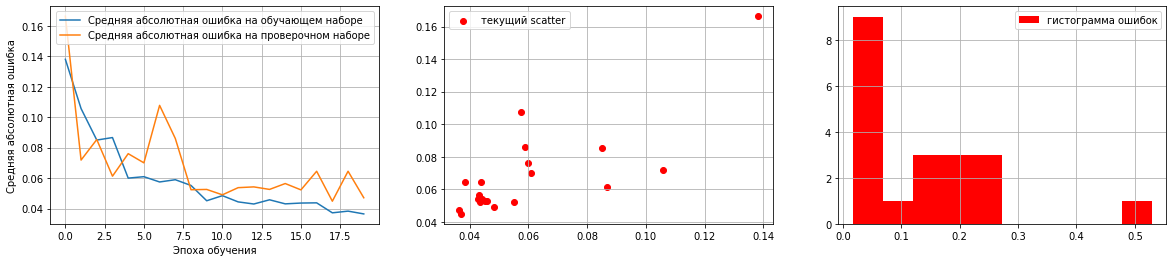

In [85]:
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], yTrainScaled[~valMask], epochs=20, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], yTrainScaled[valMask]), verbose=0, callbacks=[pltMae])

plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history["mae"], label="Средняя абсолютная ошибка на обучающем наборе")
plt.plot(history.history["val_mae"], label="Средняя абсолютная ошибка на проверочном наборе")
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.scatter(history.history["mae"], history.history["val_mae"], color="r", label="текущий scatter")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.hist(history.history["loss"], color="r", label="гистограммa ошибок")
plt.legend()
plt.grid()

plt.show()

Меняю шаг обучения на 1e-4
Эпоха №: 0 модуль ошибки: 0.917
{'loss': 0.00986074935644865, 'mae': 0.02771514281630516, 'val_loss': 0.01772434264421463, 'val_mae': 0.0405474416911602}
Bремя обучения эпохи №: 0 2.384185791015625e-07 sec Bремя обучения суммарное: 4.76837158203125e-06 sec
 Время о конца обучения: 4.5299530029296875e-06
Эпоха №: 1 модуль ошибки: 0.899
{'loss': 0.007491582073271275, 'mae': 0.023775825276970863, 'val_loss': 0.01727408729493618, 'val_mae': 0.03975515067577362}
Bремя обучения эпохи №: 1 2.384185791015625e-07 sec Bремя обучения суммарное: 4.76837158203125e-06 sec
 Время о конца обучения: 4.291534423828125e-06
Эпоха №: 2 модуль ошибки: 0.885
{'loss': 0.004085357300937176, 'mae': 0.02168523520231247, 'val_loss': 0.025512034073472023, 'val_mae': 0.039138082414865494}
Bремя обучения эпохи №: 2 2.384185791015625e-07 sec Bремя обучения суммарное: 4.76837158203125e-06 sec
 Время о конца обучения: 4.0531158447265625e-06
Эпоха №: 3 модуль ошибки: 0.898
{'loss': 0.005827554

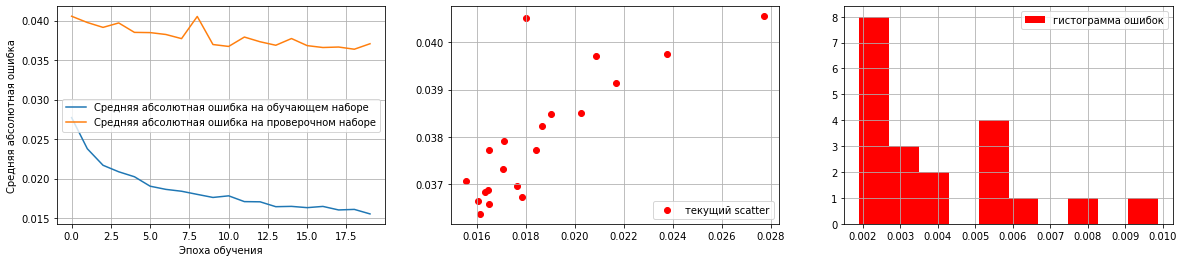

In [86]:
print("Меняю шаг обучения на 1e-4")
model.compile(optimizer=Adam(lr=1e-4), loss="mse", metrics=["mae"])

history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], yTrainScaled[~valMask], epochs=20, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], yTrainScaled[valMask]), verbose=0,callbacks=[pltMae])

plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history["mae"], label="Средняя абсолютная ошибка на обучающем наборе")
plt.plot(history.history["val_mae"], label="Средняя абсолютная ошибка на проверочном наборе")
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.scatter(history.history["mae"], history.history["val_mae"], color="r", label="текущий scatter")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.hist(history.history["loss"], color="r", label="гистограммa ошибок")
plt.legend()
plt.grid()

plt.show()

Меняю шаг обучения на 1e-5
Эпоха №: 0 модуль ошибки: 0.824
{'loss': 0.002367421519011259, 'mae': 0.014276213012635708, 'val_loss': 0.02236257866024971, 'val_mae': 0.03644353151321411}
Bремя обучения эпохи №: 0 2.384185791015625e-07 sec Bремя обучения суммарное: 4.76837158203125e-06 sec
 Время о конца обучения: 4.5299530029296875e-06
Эпоха №: 1 модуль ошибки: 0.821
{'loss': 0.0019723388832062483, 'mae': 0.013999592512845993, 'val_loss': 0.02046223171055317, 'val_mae': 0.03632284328341484}
Bремя обучения эпохи №: 1 2.384185791015625e-07 sec Bремя обучения суммарное: 4.76837158203125e-06 sec
 Время о конца обучения: 4.291534423828125e-06
Эпоха №: 2 модуль ошибки: 0.82
{'loss': 0.001761322608217597, 'mae': 0.013885791413486004, 'val_loss': 0.019965635612607002, 'val_mae': 0.0362665057182312}
Bремя обучения эпохи №: 2 2.384185791015625e-07 sec Bремя обучения суммарное: 4.76837158203125e-06 sec
 Время о конца обучения: 4.0531158447265625e-06
Эпоха №: 3 модуль ошибки: 0.818
{'loss': 0.0017346

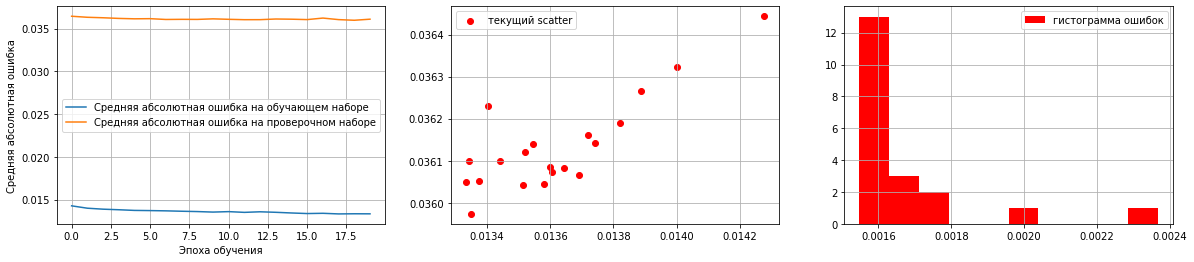

In [87]:
print("Меняю шаг обучения на 1e-5")
model.compile(optimizer=Adam(lr=1e-5), loss="mse", metrics=["mae"])
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], yTrainScaled[~valMask], epochs=20, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], yTrainScaled[valMask]), verbose=0,callbacks=[pltMae])

plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history["mae"], label="Средняя абсолютная ошибка на обучающем наборе")
plt.plot(history.history["val_mae"], label="Средняя абсолютная ошибка на проверочном наборе")
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.scatter(history.history["mae"], history.history["val_mae"], color="r", label="текущий scatter")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.hist(history.history["loss"], color="r", label="гистограммa ошибок")
plt.legend()
plt.grid()

plt.show()

In [88]:
# проверяю наличие сохраненной модели

model = load_model("/content/drive/MyDrive/moscow.h5")
model

In [178]:
# задание 6 - Изменяется ли шаг обучения, если начинается “пила” или mae выходит на плато
#  шаг обучения задан при компиляции моделей. Это 1e-3, 1e-4 и 1e-5
#  с уменьшением шага "пила" сравнивается

In [89]:
pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]])             # предсказание сети на проверочной выборке
predUnscaled = yScaler.inverse_transform(pred).flatten()                      # преобразую к изначальным величинам цен квартир
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()   # преобразую yTrain к базовым ценам
delta = predUnscaled - yTrainUnscaled                                         # разность предсказания и правильных цен
absDelta = abs(delta)                                                         # модуль отклонения
print("Модуль ошибки:", round(sum(absDelta) / (1e+6 * len(absDelta)),2), "млн.руб")                # усреднённая ошибка

Модуль ошибки: 0.82 млн.руб
